In [3]:
pip install yfinance numpy pandas scipy matplotlib seaborn

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------- ----------------------------- 0.8/3.0 MB 7.8 MB/s eta 0:00:01
     ------------------------ --------------- 1.8/3.0 MB 4.6 MB/s eta 0:00:01
     ------------------------------- -------- 2.4/3.0 MB 3.6 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 4.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------------------------- -------------- 1.0/1.6 MB 4.9 MB/s eta 0:00:01
   -------------------------------------


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [5]:
def black_scholes(S, K, T, r, sigma, option_type="call"):

    # d1 and d2 components
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == "put":
        price = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    return price


In [6]:
## data acquistion
def get_historical_volatility(ticker, days=252):
    stock =yf.Ticker(ticker)
    hist = stock.history(period='1y')
    ## calculate the daaily retuens
    hist['log_return'] = np.log(hist['Close'] / hist['Close'].shift(1))
    ## calculate anualised volatility
    volatility = hist['log_return'].std() * np.sqrt(252)
    return volatility,stock.history(period="1d")['Close'].iloc[-1]

In [7]:
## example usage
ticker_symbol = "AAPL" # Apple Inc.
vol, current_price = get_historical_volatility(ticker_symbol)
print(f"{ticker_symbol} Volatility: {vol:.2%}")
print(f"{ticker_symbol} Spot Price: ${current_price:.2f}")

AAPL Volatility: 32.34%
AAPL Spot Price: $273.81


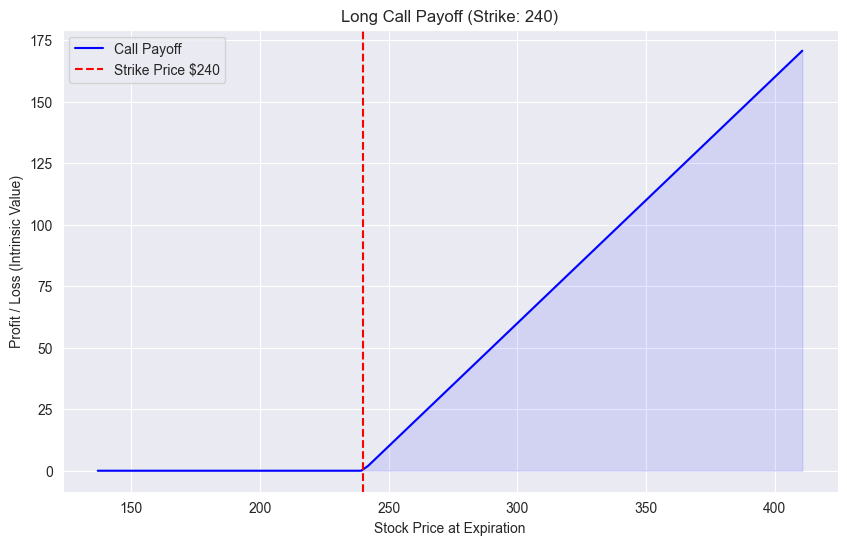

In [8]:
def plot_payoff(S, K, option_type="call"):

    # Create a range of possible stock prices at expiration
    stock_prices = np.linspace(S * 0.5, S * 1.5, 100)

    if option_type == "call":
        payoffs = np.maximum(stock_prices - K, 0)
        title = f"Long Call Payoff (Strike: {K})"
    else:
        payoffs = np.maximum(K - stock_prices, 0)
        title = f"Long Put Payoff (Strike: {K})"

    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices, payoffs, label=f'{option_type.capitalize()} Payoff', color='blue')
    plt.axvline(x=K, color='red', linestyle='--', label=f'Strike Price ${K}')
    plt.title(title)
    plt.xlabel('Stock Price at Expiration')
    plt.ylabel('Profit / Loss (Intrinsic Value)')
    plt.legend()
    plt.fill_between(stock_prices, payoffs, color='blue', alpha=0.1)
    plt.show()

# Visualize
K_example = 240 # Example Strike
plot_payoff(current_price, K_example, "call")


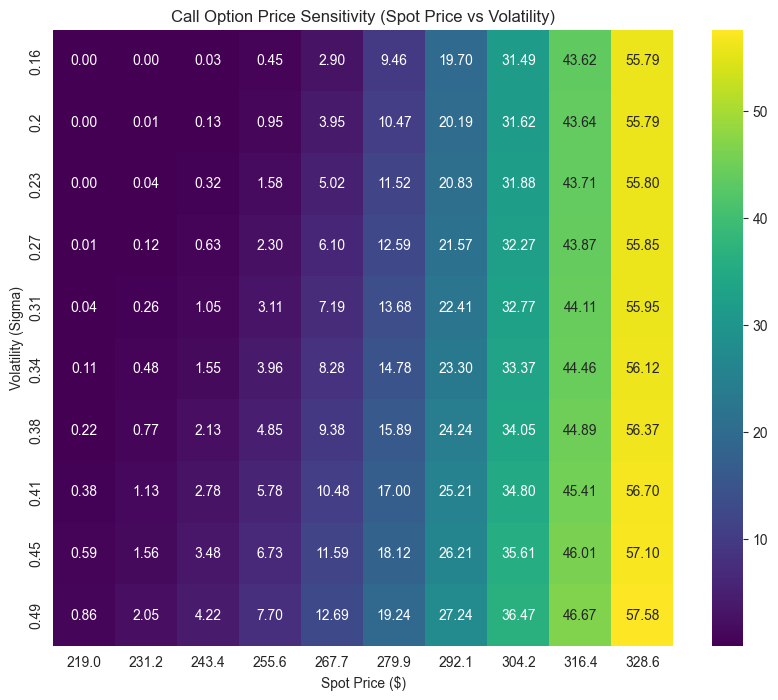

In [9]:
## sensitivvity analysis
# r is risk free rate
# time at the  expiration
# k is current price at teh money
r = 0.045
T = 1/12
K = current_price
# create ranges
spot_range = np.linspace(current_price * 0.8, current_price * 1.2,10 )
vol_range = np.linspace(vol * 0.5,vol * 1.5,10)
#Calculate prices for the grid
bs_prices = np.zeros((len(vol_range), len(spot_range)))

for i, v in enumerate(vol_range):
    for j, s in enumerate(spot_range):
        bs_prices[i, j] = black_scholes(s, K, T, r, v, "call")

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(bs_prices, xticklabels=np.round(spot_range, 1), yticklabels=np.round(vol_range, 2), annot=True, fmt=".2f", cmap="viridis")
plt.title("Call Option Price Sensitivity (Spot Price vs Volatility)")
plt.xlabel("Spot Price ($)")
plt.ylabel("Volatility (Sigma)")
plt.show()


--- NVDA DATA ---
Spot Price: $188.61
Annualized Volatility: 50.00%
Selected Expiration: 2026-01-09
Days to Expiry: 14 (T=0.0384)


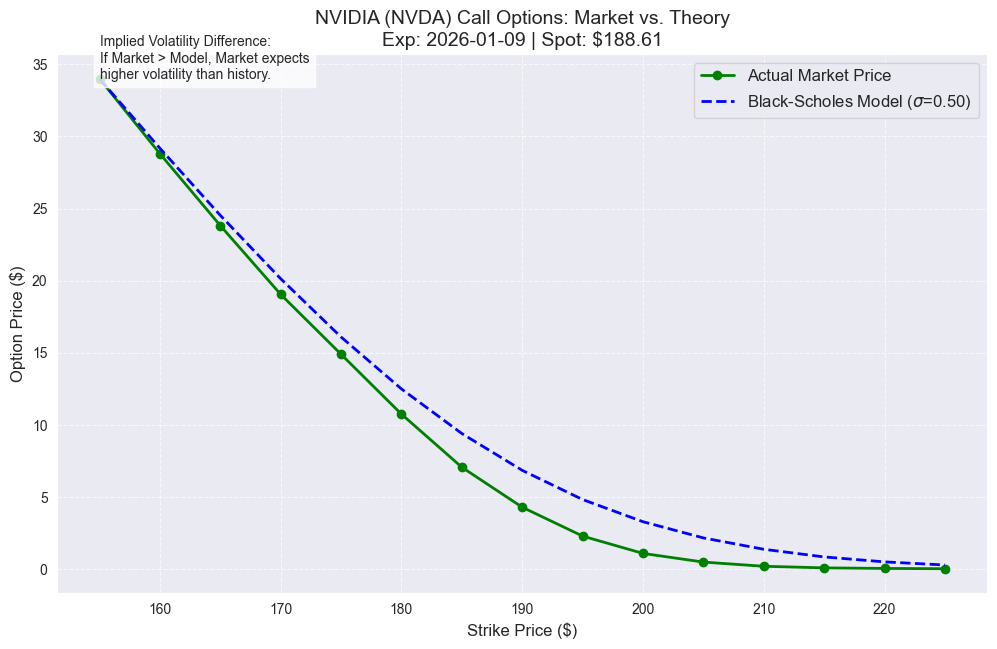


--- PRICE COMPARISON (Nearest to Spot) ---
    strike  Market_Premium   BS_Price      Diff
26   190.0            4.30   6.855988 -2.555988
25   185.0            7.07   9.407320 -2.337320
27   195.0            2.30   4.833731 -2.533731
24   180.0           10.75  12.497451 -1.747451
28   200.0            1.10   3.295852 -2.195852


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 1. SETUP VARIABLES FOR NVIDIA
ticker_symbol = "NVDA"
risk_free_rate = 0.0415  # Approx. 4.15% (Current 10-Year Treasury Yield)

# 2. GET LIVE SPOT PRICE & VOLATILITY
# We use the function we defined in Step 3 to get dynamic volatility
vol, current_price_series = get_historical_volatility(ticker_symbol)
current_price = current_price_series.item() # Extract scalar value from Series
print(f"--- {ticker_symbol} DATA ---")
print(f"Spot Price: ${current_price:.2f}")
print(f"Annualized Volatility: {vol:.2%}")

# 3. GET OPTION CHAIN
stock = yf.Ticker(ticker_symbol)
exps = stock.options

# Select an expiration date roughly 1 month out for best liquidity comparison
# We typically avoid the very first index (0) if it's expiring in < 2 days
target_date = exps[2] if len(exps) > 2 else exps[0]
print(f"Selected Expiration: {target_date}")

# Fetch the chain
opt_chain = stock.option_chain(target_date)
calls = opt_chain.calls

# 4. FILTER DATA (Important!)
# We focus on strikes "Near the Money" (±20% of spot price)
# Deep OTM/ITM options have liquidity issues that skew charts
calls = calls[(calls['strike'] > current_price * 0.8) &
              (calls['strike'] < current_price * 1.2)]

# 5. CALCULATE TIME TO MATURITY (T)
# Accurate T is crucial for the math to work
expiry_dt = datetime.strptime(target_date, "%Y-%m-%d")
today_dt = datetime.now()
days_to_expiry = (expiry_dt - today_dt).days

if days_to_expiry <= 0:
    # Handle edge case where option expires today
    T = 0.0001
else:
    T = days_to_expiry / 365.0

print(f"Days to Expiry: {days_to_expiry} (T={T:.4f})")

# 6. CALCULATE BLACK-SCHOLES PRICE VS MARKET
theoretical_prices = []

for strike in calls['strike']:
    # Use the black_scholes function defined in Step 2
    bs_p = black_scholes(current_price, strike, T, risk_free_rate, vol, "call")
    theoretical_prices.append(bs_p)

# Add to DataFrame
calls = calls.copy() # Avoid SettingWithCopy warnings
calls['BS_Price'] = theoretical_prices
calls['Market_Premium'] = calls['lastPrice']
calls['Diff'] = calls['Market_Premium'] - calls['BS_Price']

# 7. VISUALIZE THE RESULT
plt.figure(figsize=(12, 7))

# Plot Market Prices
plt.plot(calls['strike'], calls['Market_Premium'],
         label='Actual Market Price', marker='o', color='green', linewidth=2)

# Plot Theoretical Prices
plt.plot(calls['strike'], calls['BS_Price'],
         label=f'Black-Scholes Model ($\sigma$={vol:.2f})',
         linestyle='--', color='blue', linewidth=2)

# Formatting
plt.title(f"NVIDIA (NVDA) Call Options: Market vs. Theory\nExp: {target_date} | Spot: ${current_price:.2f}", fontsize=14)
plt.xlabel("Strike Price (\$)", fontsize=12)
plt.ylabel("Option Price (\$)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a text box for context
plt.text(calls['strike'].min(), calls['Market_Premium'].max(),
         f"Implied Volatility Difference:\nIf Market > Model, Market expects\nhigher volatility than history.",
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# 8. INSPECT THE DATAFRAME
# Show the top 5 strikes nearest to the current price
calls['Distance_From_Spot'] = abs(calls['strike'] - current_price)
print("\n--- PRICE COMPARISON (Nearest to Spot) ---")
print(calls.sort_values('Distance_From_Spot')[['strike', 'Market_Premium', 'BS_Price', 'Diff']].head(5))